### Import 

In [1]:
import pandas as pd
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize 
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [2]:
df = pd.read_csv("../raw_data/okcupid_profiles.csv")

### My topics to clean

essay8- The most private thing I am willing to admit

essay9- You should message me if...

status, diet, ethnicity, last_online, religion

we have decided to remove last_online

#### status

In [8]:
df['status'] = np.where(df['status'].str.contains('single'), 'available', df['status'])
df = pd.concat([pd.get_dummies(df.status, prefix='status', prefix_sep='_'), df], axis = 1)
# drop unknown since there are only a few people that fall into this category
df.drop("status_unknown", axis="columns", inplace=True)

df.status.value_counts()

available         57562
seeing someone     2064
married             310
unknown              10
Name: status, dtype: int64

#### diet

In [5]:
df.diet.fillna("no restriction", inplace=True)

# create dummy variable: strict (1=strictly following a diet)
df['strict'] = 0
df.loc[df.diet.str.contains('strictly'), 'strict'] = 1
df.loc[df.diet.str.len()==1, 'strict'] = 1

# group diets
df['diet'] = np.where(df['diet'].str.contains('strictly anything|mostly other|anything|mostly anything|strictly other|other'), 'no restriction', df['diet'])
df.loc[df.diet=='no restriction', 'strict'] = 0
df['diet'] = np.where(df['diet'].str.contains('mostly vegetarian|strictly vegan|strictly vegetarian|mostly vegan|vegan|vegetarian'), 'veggie', df['diet'])
df['diet'] = np.where(df['diet'].str.contains('mostly kosher|strictly kosher|kosher'), 'kosher', df['diet'])
df['diet'] = np.where(df['diet'].str.contains('mostly halal|strictly halal|halal'), 'halal', df['diet'])

In [7]:
df.head(30)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,strict
0,22,single,m,straight,a little extra,no restriction,socially,never,working on college/university,"asian, white",...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,0
1,35,single,m,straight,average,no restriction,often,sometimes,working on space camp,white,...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN,0
2,38,available,m,straight,thin,no restriction,socially,NaN,graduated from masters program,NaN,...,"i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",0
3,23,single,m,straight,thin,veggie,socially,NaN,working on college/university,white,...,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,0
4,29,single,m,straight,athletic,no restriction,socially,never,graduated from college/university,"asian, black, other",...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN,0
5,29,single,m,straight,average,no restriction,socially,NaN,graduated from college/university,white,...,building awesome stuff. figuring out what's im...,imagining random shit. laughing at aforementio...,i have a big smile. i also get asked if i'm we...,"books: to kill a mockingbird, lord of the ring...","like everyone else, i love my friends and fami...",what my contribution to the world is going to ...,out with my friends!,i cried on my first day at school because a bi...,you're awesome.,0
6,32,single,f,straight,fit,no restriction,socially,never,graduated from college/university,"white, other",...,digging up buried treasure,frolicking witty banter using my camera to ext...,i am the last unicorn,i like books. ones with pictures. reading them...,laughter amazing people in my life color curio...,synchronicity there is this whole other realm...,plotting to take over the world with my army o...,my typical friday night,NaN,0
7,31,single,f,straight,average,no restriction,socially,never,graduated from college/university,white,...,"writing. meeting new people, spending time wit...","remembering people's birthdays, sending cards,...",i'm rather approachable (a byproduct of being ...,"i like: alphabetized lists, aquariums, autobio...","friends, family, notebook/pen, books, music, t...",things that amuse and inspire me,out and about or relaxing at home with a good ...,NaN,NaN,0
8,24,single,f,straight,NaN,no restriction,socially,NaN,graduated from college/university,white,...,"oh goodness. at the moment i have 4 jobs, so i...",NaN,i'm freakishly blonde and have the same name a...,i am always willing to try new foods and am no...,sports/my softball glove coffee. because nobod...,NaN,"in or out... drinking with friends, maybe a ba...",potential friends/lovers/people who come in co...

#### ethnicity

We can split ethnicity into 6 big groups

white,asian,hispanic/latin,black,middle eastern

In [ ]:
df['eth_num'] = df.ethnicity.str.len()
df["ethnicity2"] = "race"
df.loc[df.eth_num<2, "ethnicity2"] = df.ethnicity.str[0]
df.loc[df.eth_num==2, "ethnicity2"] = "biracial"
df.loc[df.eth_num>2, "ethnicity2"] = "multiracial"
df.loc[df.eth_num>2, "eth_num"] = 3

In [ ]:
df.head()

#### religion

In [ ]:
(df.religion.isnull().sum()/len(df))*100

In [ ]:
df["religion"] = df["religion"].fillna('agnostic')

In [ ]:
df.religion.isnull().sum()

In [ ]:
pd.set_option('display.max_columns', None)

##### we will have to try different methods of fill NA in our model
such as fill NA as agnostic or other

#### we can also try to split the data in different ways such as
shrink into 6 categories or 
split into categories and add column for intesity 


In [ ]:
df.religion.value_counts()

##### fill NA with agnostic



In [ ]:
dfagn = df.copy()

dfagn["religion"] = df["religion"].fillna("agnosticism")

##### fill NA with other

In [ ]:
dfother = df.copy()
dfother["religion"] = df["religion"].fillna("other")

##### add features for seriousness

In [ ]:
dfagn['rel_scale'] = np.where(dfagn['religion'].str.contains("very serious"), 1, 0)

In [ ]:
def create_religion_scale(df):
    conditions = [
        df['religion'].str.contains("very serious"),
        df['religion'].str.contains("somewhat serious"),
        df['religion'].str.contains("not too serious"),
        df['religion'].str.contains("laughing")]
    choices = ['very serious', 'somewhat serious', 'not too serious','laughing']
    df['rel_scale'] = np.select(conditions, choices, default='normal')
    return df

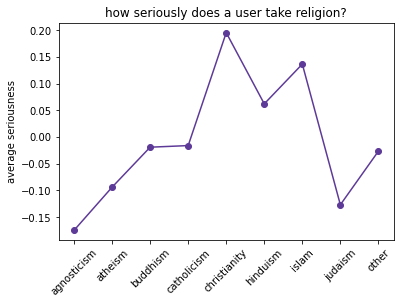

In [9]:
df.religion.fillna("other", inplace=True)

# create 1 variable: serious (1=yes, 0=neutral, -1=no)
df["serious"] = 0
df.loc[df.religion.str.contains("very|somewhat"), "serious"] = 1
df.loc[df.religion.str.contains("laughing"), "serious"] = -1
df.religion = df.religion.str.split().str[0]
# df.groupby("religion")["serious"].mean()

# seriousness by religion
plt.plot(df.groupby("religion")["serious"].mean(), marker='o', color="#5e3a98")
plt.xticks(rotation=45)
plt.title("how seriously does a user take religion?")
plt.ylabel("average seriousness")
plt.show()


In [ ]:
dfagn = create_religion_scale(dfagn)
dfagn

In [ ]:
dfother = create_religion_scale(dfother)

dfother

#### cleaning function

In [10]:
def clean (text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized


In [11]:
df['essay8']=df['essay8'].fillna('')
df['essay9']=df['essay9'].fillna('')


In [12]:
df['essay8clean'] = df['essay8'].apply(lambda x: clean(x))

In [13]:
df['essay9clean'] = df['essay9'].apply(lambda x: clean(x))

In [15]:
df['essay8clean'][0]

['new', 'california', 'looking', 'someone', 'wisper', 'secret']

In [17]:
df['essay8'][0]

'i am new to california and looking for someone to wisper my secrets to.'

In [14]:
df['essay9clean'][0]

['want',
 'swept',
 'foot',
 'tired',
 'norm',
 'want',
 'catch',
 'coffee',
 'bite',
 'want',
 'talk',
 'philosophy']

In [18]:
df['essay9'][0]

'you want to be swept off your feet! you are tired of the norm. you want to catch a coffee or a bite. or if you want to talk philosophy.'

In [ ]:
 df[df.essay0.isnull() & df.essay1.isnull() & df.essay2.isnull()& df.essay3.isnull()& df.essay4.isnull()& df.essay5.isnull()& df.essay6.isnull()& df.essay7.isnull()& df.essay8.isnull()& df.essay9.isnull()]